In [1]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Download `occupancy-detection` dataset
# using the id=357
occupancy_detection = fetch_ucirepo(id=357)

# Build the feature and the target data sets
data = occupancy_detection.data.original

In [3]:
df = data.drop(['date', 'id'], axis=1)
df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [ ]:
df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.180,27.2720,426.00,721.25,0.004793,1.0
1,23.150,27.2675,429.50,714.00,0.004783,1.0
2,23.150,27.2450,426.00,713.50,0.004779,1.0
3,23.150,27.2000,426.00,708.25,0.004772,1.0
4,23.100,27.2000,426.00,704.50,0.004757,1.0
...,...,...,...,...,...,...
20557,20.815,27.7175,429.75,1505.25,0.004213,1.0
20558,20.865,27.7450,423.50,1514.50,0.004230,1.0
20559,20.890,27.7450,423.50,1521.50,0.004237,1.0
20560,20.890,28.0225,418.75,1632.00,0.004279,1.0


In [4]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [5]:
tf.random.set_seed(4500)

In [6]:
X = df.drop(["Occupancy"], axis=1)
y = df['Occupancy']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from scipy.special import expit

class NeuronModel():

    def __init__(self, X, y, learning_rate=0.01, error_threshold=0.001) -> None:

        assert X.size != 0, "X cannot be empty"
        assert y.size != 0, "y cannot be empty"
        assert learning_rate > 0, "learning rate must be positive"

        if not isinstance(X, np.ndarray):
            X = X.to_numpy()

        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1)

        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.w = np.zeros((X.shape[1], 1))
        self.b = np.zeros((1, 1))
        self.N = X.shape[0]
        self.J_iter = list()
        self.stopping_tolerance = error_threshold

    def compute_logistic(self, w, b, X):
        return expit(X@w + b)

    def compute_cost(self, y_hat, y, N):
        L = y*np.log(y_hat) + (1-y)*np.log(1-y_hat)
        J = -L.sum() / N
        return J

    def forward_propagation(self, w, b, X):
        a = self.compute_logistic(w, b, X)
        return a

    def backward_propagation(self, y_hat, y, w, X):
        N = X.shape[0]
        gradient_w = np.multiply(y_hat - y, X).sum(axis=0)/ N
        gradient_w = gradient_w.reshape(w.shape)
        gradient_b = (y_hat - y).sum() / N
        gradient_b = gradient_b.reshape(-1,1)
        return gradient_w, gradient_b

    def update_parameters(self, param, gradient):
        return np.subtract(param, np.multiply(self.learning_rate, gradient))

    def train(self, verbose=0):

        y_hat = self.forward_propagation(self.w, self.b, self.X)
        J_prev = self.compute_cost(y_hat, self.y, self.N)
        J, current_percentage_error = 0, 100
        w, b = self.w, self.b

        while current_percentage_error > self.stopping_tolerance:
            J_prev = J

            y_hat = self.forward_propagation(w, b, self.X)

            gradient_w, gradient_b = self.backward_propagation(y_hat,
                                                               self.y,
                                                               w,
                                                               self.X)

            w = self.update_parameters(w, gradient_w)
            b = self.update_parameters(b, gradient_b)

            y_hat = self.forward_propagation(w, b, self.X)
            J = self.compute_cost(y_hat, self.y, self.N)
            self.J_iter.append(J)

            current_percentage_error = np.abs((J - J_prev)/J)*100

            if verbose:
                print(f"J_previous: {J_prev:8.6f} \t"
                      f"J_current: {J:8.6f} \t"
                      f"Error: {current_percentage_error:8.6f}")

        self.w = w
        self.b = b

    def predict(self, X):
        a = self.forward_propagation(self.w, self.b, X)
        return a

    def plot_cost_function(self):
        plt.plot(self.J_iter)
        plt.xlabel('Iteration')
        plt.ylabel(r"$J_{\mathbf{w}}$")

    def evaluate(self, y_hat, y):

        if not isinstance(y, np.ndarray):
            y = y.to_numpy().reshape(-1,1)

        y_hat[y_hat >= 0.5] = 1
        y_hat[y_hat < 0.5] = 0

        err = np.where((np.abs(y - y_hat) > 0) == True)[0]

        return 1-err.shape[0]/y.shape[0]

    def get_parameters(self):
        return np.vstack((self.w, self.b))

In [11]:
model = NeuronModel(X=X_train, y=y_train, learning_rate=1, error_threshold=0.01)
model.train(verbose=1)

J_previous: 0.000000 	J_current: 0.434288 	Error: 100.000000
J_previous: 0.434288 	J_current: 0.337854 	Error: 28.542931
J_previous: 0.337854 	J_current: 0.284542 	Error: 18.736343
J_previous: 0.284542 	J_current: 0.249663 	Error: 13.970439
J_previous: 0.249663 	J_current: 0.224651 	Error: 11.133710
J_previous: 0.224651 	J_current: 0.205647 	Error: 9.240989
J_previous: 0.205647 	J_current: 0.190621 	Error: 7.882361
J_previous: 0.190621 	J_current: 0.178390 	Error: 6.856745
J_previous: 0.178390 	J_current: 0.168207 	Error: 6.053642
J_previous: 0.168207 	J_current: 0.159579 	Error: 5.407044
J_previous: 0.159579 	J_current: 0.152161 	Error: 4.874943
J_previous: 0.152161 	J_current: 0.145707 	Error: 4.429250
J_previous: 0.145707 	J_current: 0.140035 	Error: 4.050434
J_previous: 0.140035 	J_current: 0.135007 	Error: 3.724473
J_previous: 0.135007 	J_current: 0.130516 	Error: 3.441032
J_previous: 0.130516 	J_current: 0.126478 	Error: 3.192321
J_previous: 0.126478 	J_current: 0.122827 	Error: 

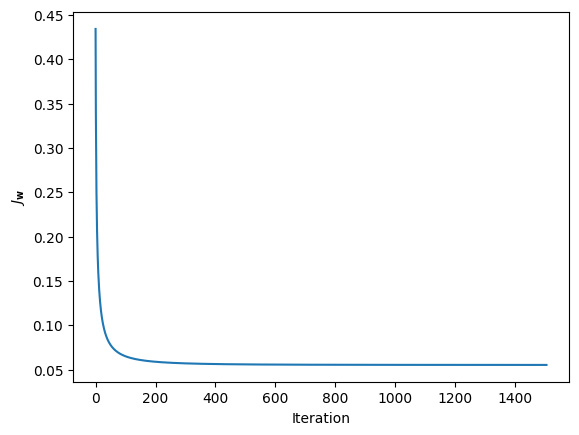

In [12]:
model.plot_cost_function()

In [13]:
y_predictions = model.predict(X=X_test)

In [14]:
model.get_parameters()

array([[-0.91581806],
       [ 0.14729331],
       [ 4.84294716],
       [ 1.09300556],
       [ 0.28690237],
       [-4.33768043]])

In [ ]:
model.evaluate(y_hat=y_predictions, y=y_test)

0.9892996108949417